In [6]:
#Define functions (Always run)

import pandas as pd
import numpy as np
from os import listdir

def read_binaries(binData='Data.bin',binX='X.bin',binY='Y.bin',metaData='Meta.dat'):
    params = {'text':'text pending'}
    with open(binData,'rb') as file:
        hdata = np.fromfile(file, dtype=np.float32)
    with open(binX,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float32)
    with open(binY,'rb') as file:
        ydata = np.fromfile(file, dtype=np.float32)
    iterations = int(len(hdata)/(len(xdata)*len(ydata)))
    Nx = int(len(xdata))
    Ny = int(len(ydata))
    hdata = hdata.reshape((iterations,Ny,Nx))
    return  xdata, ydata, hdata, params
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

c:\Users\bigba\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\bigba\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:113: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


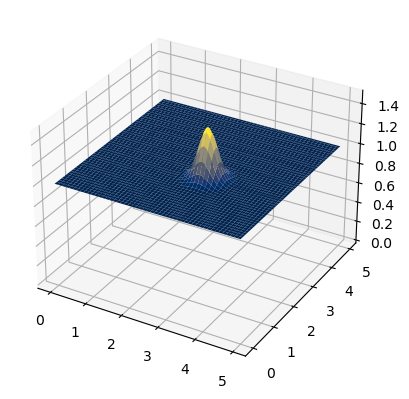

In [7]:
#animate_data('File.dat')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

x,y,f,params = read_binaries()
Nx = int(len(x))
Ny = int(len(y))

IPF = 10 #Iterations per frame

def update_plot(frame_number, zarray, plot):
    frame = frame_number*IPF
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, Zarray[frame],color='0.75',cmap='cividis')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)
Zarray = f

plot = [ax.plot_surface(X, Y, Zarray[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.5)
animate = animation.FuncAnimation(fig, update_plot, int(len(f)/IPF), fargs=(Zarray, plot))
animate.save('shallow_waters.gif',writer='pillow')

(0.0, 1.5)

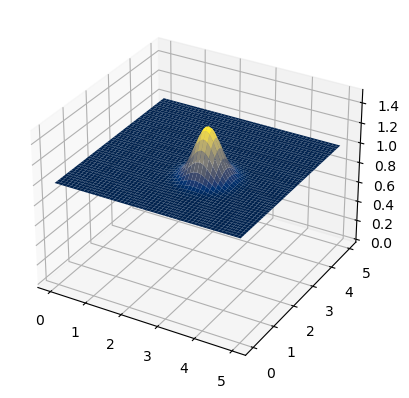

In [4]:
#Plot single image

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

x,y,f,params = read_binaries()
Nx = int(len(x))
Ny = int(len(y))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)
Zarray = f

plot = [ax.plot_surface(X, Y, Zarray[0], color='0.75', cmap='cividis')]
ax.set_zlim(0,1.5)